In [1]:
import pandas as pd

# Path to the CSV file
file_path = "../results/r_py/pls_input.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the first few rows to confirm it loaded correctly
df.head()

,Unnamed: 0,mvm_id,org_charge_eq_mg_C,mean_toc,Ingen.täckning,Öppen.våtmark,Åkermark,Hällmark,Hedmark,Hårdgjorda.ytor,...,mean_annual_temp,annual_precip,summer_NDVI,mean_Q_spec,p25_Q_spec,p75_Q_spec,stationCoordinateX,stationCoordinateY,area_ARO_m2,log_mean_Q
0,1,21,-0.000008,0.000595,0.016865,10.827516,1.489945,0.599562,9.204753,0.070732,...,2.390047,714.157996,0.688210,0.000010,0.000008,0.000014,611834,6788266,1.980088e+10,5.333019
1,2,22,-0.000008,0.001132,NaN,4.435932,4.546848,0.048565,2.688512,0.308961,...,5.190270,698.184020,NaN,0.000006,0.000003,0.000011,616191,6728334,2.451777e+09,2.654065
2,3,23,-0.000007,0.000974,0.000000,2.334196,14.349830,0.127254,5.395506,0.279148,...,6.836743,649.505305,0.755722,0.000004,0.000003,0.000008,611899,6520892,3.586839e+09,2.707292
3,4,24,-0.000006,0.000666,0.000000,1.931073,13.276127,0.060056,5.637193,0.368191,...,6.857753,675.444736,0.747521,0.000006,0.000004,0.000008,565175,6495264,1.537073e+10,4.442619
4,5,25,-0.000007,0.001507,NaN,2.921117,2.812339,0.024083,4.944223,0.313033,...,7.320340,715.777359,NaN,0.000005,0.000002,0.000012,540991,6228238,8.051260e+08,1.416389


map of sweden and its mean charge density 

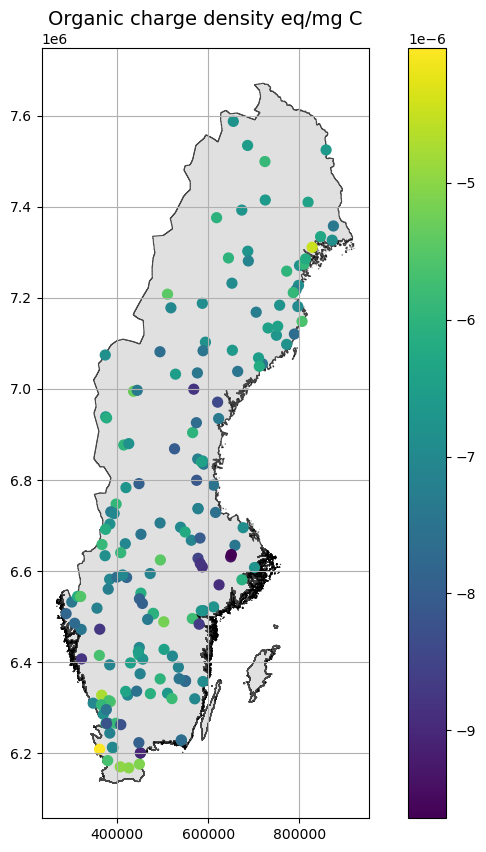

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Step 2: Convert to GeoDataFrame with SWEREF 99TM CRS
geometry = [Point(xy) for xy in zip(df["stationCoordinateX"], df["stationCoordinateY"])]
stations_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:3006")  # SWEREF 99TM CRS

# Step 3: Load Sweden shapefile and ensure it's in SWEREF 99TM
sweden_shapefile = "../input/shapefiles/Sweden.zip"
sweden_gdf = gpd.read_file(f"zip://{sweden_shapefile}")
sweden_gdf = sweden_gdf.to_crs("EPSG:3006")  # Ensure CRS matches SWEREF 99TM

# Step 4: Plot the map in SWEREF 99TM
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the Sweden outline
sweden_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.8, alpha=0.7)

# Plot the station points, colored by 'org_charge_eq_mg_C'
stations_gdf.plot(
    ax=ax,
    column="org_charge_eq_mg_C",  # Column to determine color
    cmap="viridis",              # Color map (can be adjusted to your preference)
    markersize=50,
    legend=True
)

# Finalize the plot
plt.title("Organic charge density eq/mg C", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.grid(True)
plt.show()


In [10]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure
from bokeh.palettes import Viridis256
from bokeh.transform import linear_cmap


# Ensure Bokeh plots are displayed in the notebook (if using Jupyter)
output_notebook()

# Step 1: Create a GeoDataFrame for station data
geometry = [Point(xy) for xy in zip(df["stationCoordinateX"], df["stationCoordinateY"])]
stations_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:3006")  # SWEREF 99TM CRS

# Step 2: Load Sweden shapefile and ensure CRS matches SWEREF 99TM
sweden_shapefile = "../input/shapefiles/Sweden.zip"
sweden_gdf = gpd.read_file(f"zip://{sweden_shapefile}")
sweden_gdf = sweden_gdf.to_crs("EPSG:3006")

# Step 3: Convert Sweden and station data to Web Mercator (EPSG:3857) for Bokeh compatibility
stations_gdf = stations_gdf.to_crs("EPSG:3857")
sweden_gdf = sweden_gdf.to_crs("EPSG:3857")

# Prepare station data for Bokeh
stations_gdf["x"] = stations_gdf.geometry.x
stations_gdf["y"] = stations_gdf.geometry.y
stations_source = ColumnDataSource(stations_gdf)

# Define color mapping for 'org_charge_eq_mg_C'
color_mapper = linear_cmap(
    field_name="org_charge_eq_mg_C",
    palette=Viridis256,
    low=stations_gdf["org_charge_eq_mg_C"].min(),
    high=stations_gdf["org_charge_eq_mg_C"].max()
)

# Step 4: Create a Bokeh plot
plot = figure(
    title="Organic Charge Density eq/mg C",
    x_axis_type="mercator",
    y_axis_type="mercator",
    width=800,
    height=800,
    tooltips=[("Station ID", "@stationID"), ("Charge", "@org_charge_eq_mg_C")]
)



# Plot the Sweden outline
for geom in sweden_gdf.geometry:
    if geom.geom_type == "Polygon":
        xs, ys = geom.exterior.xy
        plot.patch(xs, ys, color="lightgrey", line_color="black", alpha=0.7)
    elif geom.geom_type == "MultiPolygon":
        for sub_geom in geom.geoms:  # Use the .geoms attribute to iterate over polygons
            xs, ys = sub_geom.exterior.xy
            plot.patch(xs, ys, color="lightgrey", line_color="black", alpha=0.7)

# Add station points with hover functionality
plot.scatter(
    x="x",
    y="y",
    source=stations_source,
    size=8,
    color=color_mapper,
    line_color="black",
    fill_alpha=0.8,
    legend_label="Stations"
)

# Add hover tool for station points
hover_tool = HoverTool(
    tooltips=[
        ("Station ID", "@stationID"),
        ("Charge (mg C)", "@org_charge_eq_mg_C"),
        ("Coordinates", "(@x, @y)")
    ]
)
plot.add_tools(hover_tool)

# Configure plot layout
plot.legend.location = "top_left"
plot.legend.title = "Stations"
plot.axis.visible = False

# Show the plot
show(plot)


Loading BokehJS ...

SerializationError: can't serialize <class 'shapely.geometry.point.Point'>

In [5]:
import bokeh
print(bokeh.__version__)  # Should print the updated version, ideally 3.0.0 or higher
from bokeh.tile_providers import get_provider, Vendors  # This should now work without error


3.6.2


ModuleNotFoundError: No module named 'bokeh.tile_providers'

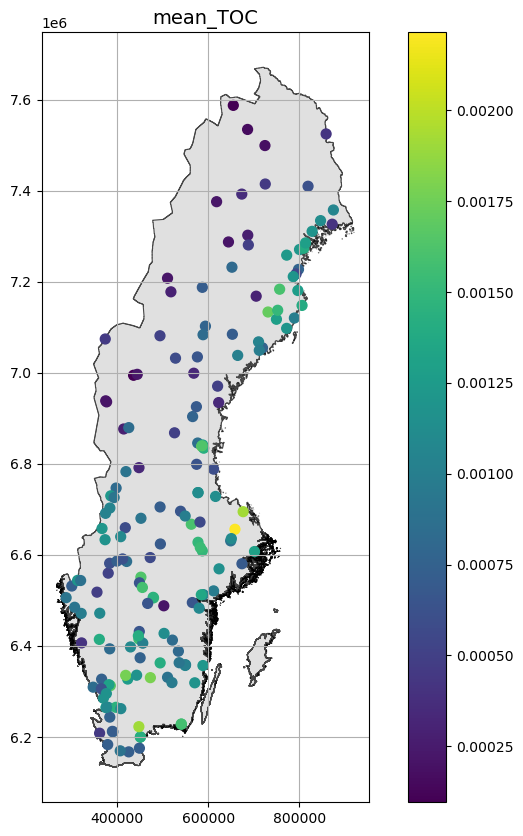

In [8]:
# Step 4: Plot the map in SWEREF 99TM
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the Sweden outline
sweden_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.8, alpha=0.7)

# Plot the station points, colored by 'org_charge_eq_mg_C'
stations_gdf.plot(
    ax=ax,
    column="mean_toc",  # Column to determine color
    cmap="viridis",              # Color map (can be adjusted to your preference)
    markersize=50,
    legend=True
)

# Finalize the plot
plt.title("mean_TOC", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.grid(True)
plt.show()

map of catchments

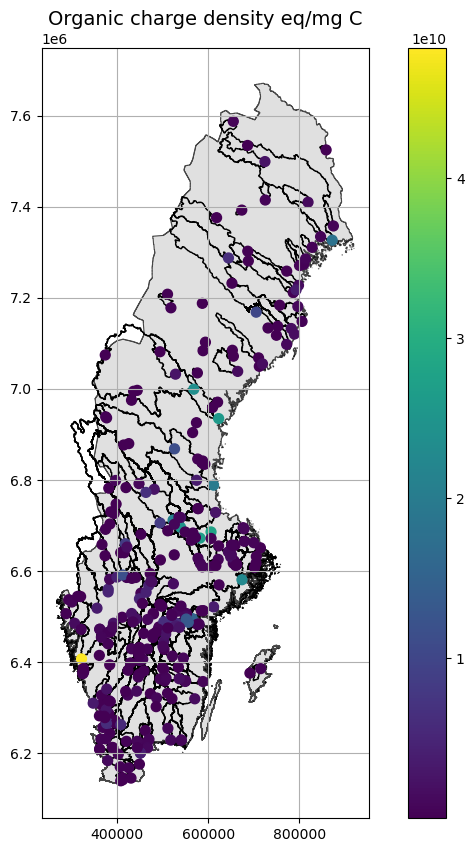

In [ ]:
import pandas as pd
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Path to the CSV file
file_path = "../input/shapefiles/catch_316.zip"

# Load the CSV file into a DataFrame
sweden_shapefile = "../input/shapefiles/Sweden.zip"
gdf = gpd.read_file(f"zip://{sweden_shapefile}")
# Step 2: Convert to GeoDataFrame with SWEREF 99TM CRS

catch_gdf = gpd.read_file(f"zip://{file_path}")  # SWEREF 99TM CRS

geometry = [Point(xy) for xy in zip(catch_gdf["lon"], catch_gdf["lat"])]
stations_gdf = gpd.GeoDataFrame(catch_gdf.drop(columns="geometry"), geometry=geometry, crs="EPSG:3006")

# Step 3: Load Sweden shapefile and ensure it's in SWEREF 99TM
sweden_shapefile = "../input/shapefiles/Sweden.zip"
sweden_gdf = gpd.read_file(f"zip://{sweden_shapefile}")
sweden_gdf = sweden_gdf.to_crs("EPSG:3006")  # Ensure CRS matches SWEREF 99TM

# Step 4: Plot the map in SWEREF 99TM
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the Sweden outline
sweden_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.8, alpha=0.7)

# Plot the station points, colored by 'org_charge_eq_mg_C'
catch_gdf.plot(
    ax=ax,  # Column to determine color
    edgecolor = "black", 
    facecolor = "none")

stations_gdf.plot(
    ax=ax,
    column="Shape_Area",  # Column to determine color
    cmap="viridis",              # Color map (can be adjusted to your preference)
    markersize=50,
    legend=True
)

# Finalize the plot
plt.title("Organic charge density eq/mg C", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.grid(True)
plt.show()
